In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset
import matplotlib.pyplot as plt
from lstm_net import LSTM

(1180, 301, 6) (955, 301, 6) (118, 301, 6) (107, 301, 6) (955,)


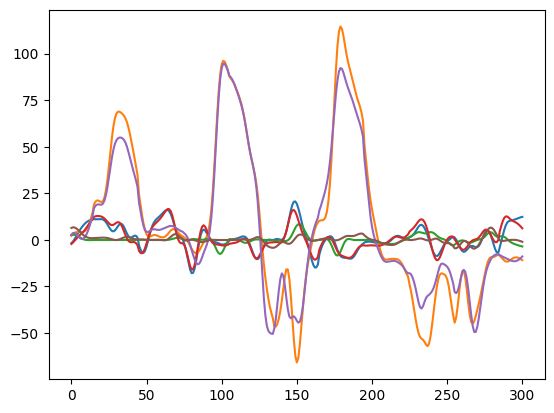

In [2]:
#load data
'''AC = np.load('C:\Github_LIU\SII2025\process_data\classifier\AC.npy')
AD = np.load('C:\Github_LIU\SII2025\process_data\classifier\AD.npy')
BC = np.load('C:\Github_LIU\SII2025\process_data\classifier\BC.npy')
BD = np.load('C:\Github_LIU\SII2025\process_data\classifier\BD.npy')'''
AC = np.load('/Users/syunsei/Desktop/SII2025/process_data/classifier/AC.npy')
AD = np.load('/Users/syunsei/Desktop/SII2025/process_data/classifier/AD.npy')
BC = np.load('/Users/syunsei/Desktop/SII2025/process_data/classifier/BC.npy')
BD = np.load('/Users/syunsei/Desktop/SII2025/process_data/classifier/BD.npy')
#split data into training and testing and validation
AC=np.concatenate ((AC[:,:,0:3],AC[:,:,6:9]), axis=2)
AD=np.concatenate ((AD[:,:,0:3],AD[:,:,6:9]), axis=2)  
BC=np.concatenate ((BC[:,:,0:3],BC[:,:,6:9]), axis=2)
BD=np.concatenate ((BD[:,:,0:3],BD[:,:,6:9]), axis=2)

X = np.concatenate((AC, AD, BC, BD), axis=0)
AC_labels = [0] * len(AC)
AD_labels = [1] * len(AD)
BC_labels = [2] * len(BC)
BD_labels = [3] * len(BD)
y = np.concatenate((AC_labels, AD_labels, BC_labels, BD_labels), axis=0)
#归一化
def min_max_normalize(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    range_val = max_val - min_val
    range_val[range_val == 0] = 1  # 防止除零错误
    return (data - min_val) / range_val
#X = min_max_normalize(X)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)
print(X.shape,X_train.shape, X_test.shape, X_val.shape,y_train.shape)
#draw X_train
plt.plot(X[1110])
plt.show()

batch_size = 100
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [3]:
#define hyperparameters
sequence_len = 301
input_len = 6
hidden_size = 128
num_layers = 2
num_classes = 4
num_epochs = 100
learning_rate = 0.01

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
model = LSTM(input_len, hidden_size, num_layers, num_classes).to(device)
print(model)

LSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
)


In [6]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
def train(num_epochs, model, train_loader, loss_function):
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        for batch, (lifts, labels) in enumerate(train_loader):
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            loss = loss_function(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch+1) % 2 == 0:
                loss_list.append(loss.item())
                print(f"Epoch [{epoch+1}; Batch {batch+1}/{total_step}]; Loss: {loss.item():.4f}")
                
loss_list = []
#draw learning curve
def plot_learning_curve(loss_list):
    plt.plot(loss_list, label="loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
    
train(num_epochs, model, train_loader, loss_function)
plot_learning_curve(loss_list)


Epoch [1; Batch 2/10]; Loss: 1.5030
Epoch [1; Batch 4/10]; Loss: 1.3836
Epoch [1; Batch 6/10]; Loss: 1.3612
Epoch [1; Batch 8/10]; Loss: 1.3820


KeyboardInterrupt: 

In [ ]:
def validate(model, val_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in val_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Validation accuracy: {100 * correct / total}%")

validate(model, val_loader)

Validation accuracy: 98.13084112149532%


In [ ]:
def test(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in test_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Test accuracy: {100 * correct / total}%")

test(model, test_loader)

Test accuracy: 98.30508474576271%


In [ ]:
#save model
torch.save(model.state_dict(), "model.pth")
